# <h1><center>Quality Diversity Tutorial</center></h1>

This notebook provides an introductory tutorial to Quality Diversity algorithms. Specifically, we will apply MAP-Elites to acquire a diverse set of locomotion behaviours for a simplified brittle star robot. The [brittle star robot and its environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star) is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). Instead of directly evolving joint-level actions, we will evolve modulation parameters for a Central Pattern Generator, that in turn outputs the joint-level actions.

## Quality Diversity algorithms

* Todo: short intro on Quality-Diversity algorithms
    * Evolutionary algorithm
    * Try to simultaneously maximise diversity and quality 

### MAP-Elites

* Todo: short intro on MAP-Elites
    * Show picture of algorithm
* Basic implementation shown below: genome here is just an array of parameters (i.e. direct encoding) 

In [1]:
from functools import partial
import chex
import tqdm
from flax import struct
import jax.numpy as jnp
import jax
from typing import Tuple, Type, Callable


@struct.dataclass
class MAPElitesState:
    parameter_archive: jnp.ndarray
    fitness_archive: jnp.ndarray
    descriptor_archive: jnp.ndarray
    filled_mask: jnp.ndarray


class MAPElites:
    def __init__(
            self,
            dimensions: Tuple[int, ...],
            num_parameters: int,
            noise_scale: float,
            descriptor_low: jnp.ndarray,
            descriptor_high: jnp.ndarray,
            parameters_low: jnp.ndarray,
            parameters_high: jnp.ndarray,
            evaluation_fn: Callable[[chex.PRNGKey, jnp.ndarray], jnp.ndarray]
            ) -> None:
        self._dimensions = dimensions
        self._num_parameters = num_parameters
        self._noise_scale = noise_scale
        self._descriptor_low = descriptor_low
        self._descriptor_high = descriptor_high
        self._parameters_low = parameters_low
        self._parameters_high = parameters_high
        self._evaluation_fn = evaluation_fn

    @partial(jax.jit, static_argnums=(0,))
    def _select_random_parameters(
            self,
            rng: chex.PRNGKey,
            state: MAPElitesState
            ) -> jnp.ndarray:
        """
        Returns a random cell's parameters
        """
        cell_index = jax.random.randint(
                key=rng,
                shape=(len(self._dimensions),),
                minval=jnp.zeros(len(self._dimensions)),
                maxval=jnp.array(self._dimensions)
                )
        parameters = state.parameter_archive[*cell_index]
        return parameters

    @partial(jax.jit, static_argnums=(0,))
    def _mutate_parameters(
            self,
            rng: chex.PRNGKey,
            parameters: jnp.ndarray
            ) -> jnp.ndarray:
        noise = jax.random.normal(key=rng, shape=(len(parameters),)) * self._noise_scale
        parameters = parameters + noise
        parameters = jnp.clip(a=parameters, a_min=self._parameters_low, a_max=self._parameters_high)
        return parameters

    @partial(jax.jit, static_argnums=(0,))
    def _get_cell_index(
            self,
            descriptor: jnp.ndarray
            ) -> Tuple[int, ...]:
        descriptor = jnp.clip(a=descriptor, a_min=self._descriptor_low, a_max=self._descriptor_high)

        # Renormalize descriptor to [0, 1] range
        descriptor = (descriptor - self._descriptor_low) / (self._descriptor_high - self._descriptor_low)
        cell_index = (descriptor * jnp.array(self._dimensions)).astype(jnp.int32)
        return cell_index

    @partial(jax.jit, static_argnums=(0,))
    def _add_to_archive(
            self,
            state: MAPElitesState,
            descriptor: jnp.ndarray,
            fitness: float,
            parameters: jnp.ndarray
            ) -> MAPElitesState:
        cell_index = self._get_cell_index(descriptor=descriptor)

        pred = ~state.filled_mask[*cell_index] | (fitness > state.fitness_archive[*cell_index])

        def _replace() -> MAPElitesState:
            # noinspection PyUnresolvedReferences
            return state.replace(
                    parameter_archive=state.parameter_archive.at[*cell_index].set(parameters),
                    fitness_archive=state.fitness_archive.at[*cell_index].set(fitness),
                    descriptor_archive=state.descriptor_archive.at[*cell_index].set(descriptor),
                    filled_mask=state.filled_mask.at[*cell_index].set(True)
                    )

        def _do_not_replace() -> MAPElitesState:
            return state

        return jax.lax.cond(
                pred, _replace, _do_not_replace
                )

    @partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: MAPElitesState,
            rng: chex.PRNGKey
            ) -> MAPElitesState:
        selection_rng, mutation_rng, evaluation_rng = jax.random.split(key=rng, num=3)

        parameters = self._select_random_parameters(rng=selection_rng, state=state)
        parameters = self._mutate_parameters(rng=mutation_rng, parameters=parameters)

        fitness, descriptor = self._evaluation_fn(evaluation_rng, parameters)

        state = self._add_to_archive(
                state=state, fitness=fitness, descriptor=descriptor, parameters=parameters
                )

        return state

    @partial(jax.jit, static_argnums=(0,))
    def reset(
            self,
            rng: chex.PRNGKey
            ) -> MAPElitesState:
        # noinspection PyArgumentList
        return MAPElitesState(
                parameter_archive=jax.random.uniform(
                        key=rng,
                        shape=self._dimensions + (len(self._parameters_low),),
                        dtype=jnp.float32,
                        minval=self._parameters_low,
                        maxval=self._parameters_high
                        ),
                fitness_archive=-jnp.inf * jnp.ones(self._dimensions),
                descriptor_archive=jnp.zeros(self._dimensions + (len(self._descriptor_low),)),
                filled_mask=jnp.zeros(self._dimensions).astype(bool)
                )

## Case study: CPG modulations for brittle star locomotion

* Todo: explain goals
    * We will use MAP-Elites to acquire a diverse set of locomotion behaviours (i.e. gaits) for a simplified brittle star robot
    * Our diversity: final XY position after 5 seconds of simulation
    * Our quality: distance travelled over energy usage (i.e. if two gaits result in the same end position, we'll give preference to the one that has a better distance / energy tradeoff)
* Our gaits will be encoded by CPGs, so our parameters will be the modulation of a CPG

### CPG system and modulation parameters

* No coupling between oscillators of different arms
* 2 oscillators per arm (one in plane, one out-of-plane)
    * all segments of arm share these outputs
* Parameters
    * 1 common frequency
    * Per arm: 2 oscillators:
        * Per oscillator amplitude, offset
        * phase bias for coupling 

* 5 armed brittle star, 3 segments per arm, arm segments behave the same -> 2 oscillators per arm -> 10 oscillators in total -> 30 parameters (oscillator ones) + 1 (common frequency)

### Environment setup

The next cell does some preliminary checks:
- is a GPU available
- is MuJoCo (the underlying simulator) correctly installed

In [2]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Thu Feb  1 23:24:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   46C    P8               8W /  60W |      4MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

This cell defines our environment and prepares some utility functions for creating and rendering the environment. 

In [3]:
from brb.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from brb.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration
import numpy as np
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from typing import List
import mediapy as media
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=3, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(3, 3), sand_ground_color=False, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )


def create_environment() -> BrittleStarUndirectedLocomotionEnvironment:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarUndirectedLocomotionEnvironment.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend="MJX"
            )
    return env


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None],
        path: str | None = None
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(
                f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379)."
                )
    if path:
        media.write_video(path=path, images=filtered_images)
    return media.show_video(images=filtered_images)

Now we can create our environment and `jax.jit` the `step` and `reset` functions. As we will never change this environment, we only need to do this once. 

In [4]:
rng = jax.random.PRNGKey(seed=0)
env = create_environment()
env_reset_fn = jax.jit(env.reset)
env_step_fn = jax.jit(env.step)

Always a good idea to check the observation and action space of the environment (sheds some light on what it gives us and what it expects as input).

Observation space:
Dict('joint_position': Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (15,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>))

Action space:
Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>)


""

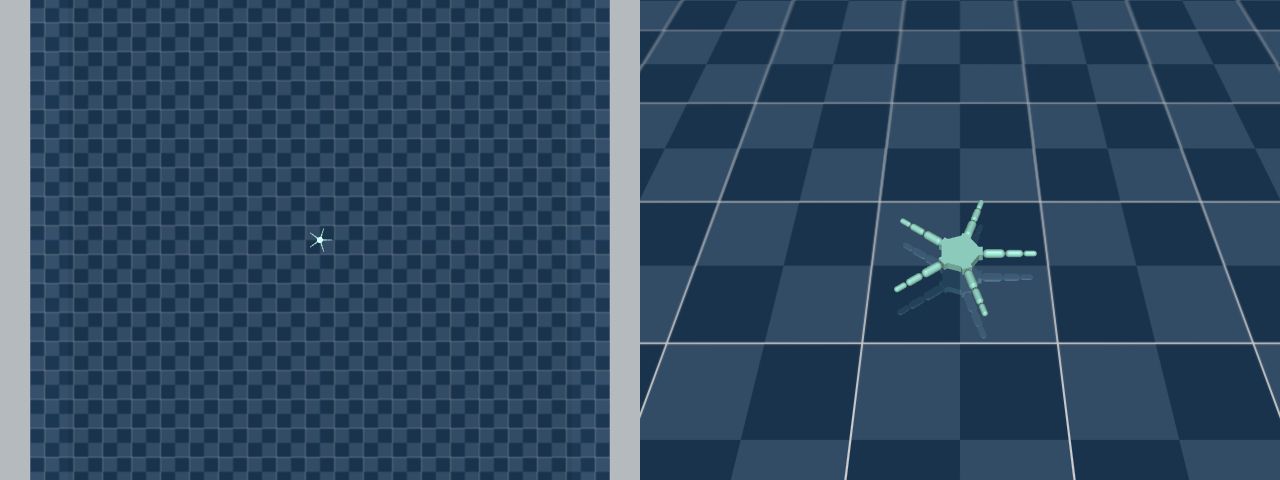

In [5]:
print("Observation space:")
print(env.observation_space)
print()
print("Action space:")
print(env.action_space)
rng, sub_rng = jax.random.split(rng, 2)
env_state = env_reset_fn(rng=sub_rng)
media.show_image(post_render(env.render(env_state), environment_configuration=env.environment_configuration))

### CPG Setup

* Same as in CPG tutorial, only difference is that we will not be coupling the oscillators of different arms.

In [6]:
import functools
from flax import struct
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Tuple

from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

    # We'll make these modulatory parameters part of the state as they will change as well
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


class CPG:
    def __init__(
            self,
            weights: jnp.ndarray,
            amplitude_gain: float = 20,
            offset_gain: float = 20,
            dt: float = 0.01, ) -> None:
        self._weights = weights
        self._amplitude_gain = amplitude_gain
        self._offset_gain = offset_gain
        self._dt = dt
        self._solver = euler_solver

    @property
    def num_oscillators(
            self
            ) -> int:
        return self._weights.shape[0]

    @staticmethod
    def phase_de(
            weights: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray,
            phase_biases: jnp.ndarray,
            omegas: jnp.ndarray
            ) -> jnp.ndarray:
        @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
        def sine_term(
                phase_i: float,
                phase_biases_i: float
                ) -> jnp.ndarray:
            return jnp.sin(phases - phase_i - phase_biases_i)

        couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
        return omegas + couplings

    @staticmethod
    def second_order_de(
            gain: jnp.ndarray,
            modulator: jnp.ndarray,
            values: jnp.ndarray,
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return gain * ((gain / 4) * (modulator - values) - dot_values)

    @staticmethod
    def first_order_de(
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return dot_values

    @staticmethod
    def output(
            offsets: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray
            ) -> jnp.ndarray:
        return offsets + amplitudes * jnp.cos(phases)

    def reset(
            self,
            rng: chex.PRNGKey
            ) -> CPGState:
        phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
        # noinspection PyArgumentList
        state = CPGState(
                phases=jax.random.uniform(
                        key=phase_rng, shape=(self.num_oscillators,), dtype=jnp.float32, minval=-0.01, maxval=0.01
                        ),
                amplitudes=jnp.zeros(self.num_oscillators),
                offsets=jnp.zeros(self.num_oscillators),
                dot_amplitudes=jnp.zeros(self.num_oscillators),
                dot_offsets=jnp.zeros(self.num_oscillators),
                outputs=jnp.zeros(self.num_oscillators),
                time=0.0,
                R=jnp.zeros(self.num_oscillators),
                X=jnp.zeros(self.num_oscillators),
                omegas=jnp.zeros(self.num_oscillators),
                rhos=jnp.zeros_like(self._weights)
                )
        return state

    @functools.partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: CPGState
            ) -> CPGState:
        new_phases = self._solver(
                current_time=state.time,
                y=state.phases,
                derivative_fn=lambda
                    t,
                    y: self.phase_de(
                        omegas=state.omegas,
                        amplitudes=state.amplitudes,
                        phases=y,
                        phase_biases=state.rhos,
                        weights=self._weights
                        ),
                delta_time=self._dt
                )
        new_dot_amplitudes = self._solver(
                current_time=state.time,
                y=state.dot_amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._amplitude_gain, modulator=state.R, values=state.amplitudes, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_amplitudes = self._solver(
                current_time=state.time,
                y=state.amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_amplitudes),
                delta_time=self._dt
                )
        new_dot_offsets = self._solver(
                current_time=state.time,
                y=state.dot_offsets,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._offset_gain, modulator=state.X, values=state.offsets, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_offsets = self._solver(
                current_time=0,
                y=state.offsets,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_offsets),
                delta_time=self._dt
                )

        new_outputs = self.output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
        # noinspection PyUnresolvedReferences
        return state.replace(
                phases=new_phases,
                dot_amplitudes=new_dot_amplitudes,
                amplitudes=new_amplitudes,
                dot_offsets=new_dot_offsets,
                offsets=new_offsets,
                outputs=new_outputs,
                time=state.time + self._dt
                )


def create_cpg() -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))

    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, ip_oscillator_indices].set(1)

    return CPG(
            weights=5 * adjacency_matrix,
            amplitude_gain=20,
            offset_gain=20,
            dt=environment_configuration.control_timestep
            )


@jax.jit
def map_cpg_outputs_to_actions(
        cpg_state: CPGState
        ) -> jnp.ndarray:
    num_arms = morphology_specification.number_of_arms
    num_oscillators_per_arm = 2
    num_segments_per_arm = morphology_specification.number_of_segments_per_arm[0]

    cpg_outputs_per_arm = cpg_state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

### Evaluation function

Now we can write our evaluation function, i.e. the function that takes in some parameters and returns the resulting fitness and behaviour descriptor.
In this case, the parameters are the CPG modulation parameters, the fitness is the negated amount of "energy" (we negate because we always maximise fitness), and the behaviour descriptor is the final XY position of the robot at the end of the episode.

Let's start by implementing a helper function that takes in parameters and actually modulates the CPG with them.

In [7]:
def modulate_cpg(
        cpg_state: CPGState,
        parameters: jnp.ndarray
        ) -> CPGState:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    R = parameters[:10]
    X = parameters[10: 20]
    omega = parameters[21]
    phase_biases = parameters[21:]

    # phase biases is a list of 5 elements, which denote the phase bias between the IP and OOP oscillator of every arm
    rhos = cpg_state.rhos.at[ip_oscillator_indices, oop_oscillator_indices].set(phase_biases)
    rhos = rhos.at[oop_oscillator_indices, ip_oscillator_indices].set(-phase_biases)
    # noinspection PyUnresolvedReferences
    return cpg_state.replace(
            R=R, X=X, omegas=jnp.ones_like(cpg_state.omegas) * omega, rhos=rhos
            )

Now we can implement the actual evaluation function. This function takes in the modulation parameters, modulates the CPG with it, and then uses that CPG to control a brittle star during a single episode. Afterwards, it returns the fitness ($\frac{\mathrm{distance\_travelled}}{\mathrm{energy\_used}}$, with joint actuator forces providing the closest proxy that our simulator can give us to actual "energy usage") and behaviour descriptor (final XY position).

In [27]:
from mujoco_utils.environment.mjx_env import MJXEnvState
from typing import Any, Dict

cpg = create_cpg()


def evaluate_parameters(
        rng: chex.PRNGKey,
        modulation_parameters: jnp.ndarray
        ) -> Tuple[float, jnp.ndarray]:
    env_rng, cpg_rng = jax.random.split(rng, 2)
    env_state = env_reset_fn(rng=env_rng)
    cpg_state = cpg.reset(rng=cpg_rng)

    cpg_state = modulate_cpg(cpg_state=cpg_state, parameters=modulation_parameters)

    def _take_step(
            _state: Tuple[MJXEnvState, CPGState],
            _: None
            ) -> Tuple[Tuple[MJXEnvState, CPGState], Dict[str, Any]]:
        _env_state, _cpg_state = _state

        actions = map_cpg_outputs_to_actions(cpg_state=_cpg_state)
        actions = jnp.clip(a=actions, a_min=env.action_space.low, a_max=env.action_space.high)

        _next_env_state = env_step_fn(state=_env_state, action=actions)
        _next_cpg_state = cpg.step(state=_cpg_state)

        carry = (_next_env_state, _next_cpg_state)
        return carry, jnp.average(jnp.abs(_env_state.observations["joint_actuator_force"]))

    carry, scan_out = jax.lax.scan(
            _take_step, (env_state, cpg_state), (), env.environment_configuration.total_num_control_steps
            )

    
    average_energy_use = jnp.average(scan_out)
    final_xy_position = carry[0].observations["disk_position"][:2][::-1]
    final_distance_from_origin = jnp.linalg.norm(final_xy_position)

    fitness = final_distance_from_origin / average_energy_use
    descriptor = final_xy_position

    return fitness, descriptor

### Optimization

We now have everything to run MAP-Elites! First some setup:

In [28]:
DESCRIPTOR_LOW = -3 * jnp.ones(2)
DESCRIPTOR_HIGH = 3 * jnp.ones(2)
PARAMETERS_LOW = jnp.concatenate(
        (jnp.zeros(10), -jnp.ones(10), jnp.zeros(1), -jnp.pi * jnp.ones(5))
        )
PARAMETERS_HIGH = jnp.concatenate(
        (jnp.ones(10), jnp.ones(10), 3 * jnp.pi * jnp.ones(1), jnp.pi * jnp.ones(5))
        )

map_elites = MAPElites(
        dimensions=(30, 30),
        num_parameters=31,
        noise_scale=0.1,
        descriptor_low=DESCRIPTOR_LOW,
        descriptor_high=DESCRIPTOR_HIGH,
        parameters_low=PARAMETERS_LOW,
        parameters_high=PARAMETERS_HIGH,
        evaluation_fn=evaluate_parameters
        )

rng, reset_rng = jax.random.split(rng, 2)
state = map_elites.reset(rng=reset_rng)

The next cell does a single iteration of our MAP-Elites algorithm (note that the first call will be slow due to jit compilation):

In [29]:
rng, iteration_rng = jax.random.split(rng, 2)
state = map_elites.step(
        state=state, rng=iteration_rng
        )

### Vectorization
As always, since we're using JAX, we will exploit the power of our GPU and vectorize things. In this case, we will run these MAP-Elites steps in parallel: 

In [30]:
vectorized_iteration = jax.jit(jax.vmap(map_elites.step, in_axes=(None, 0)))

In [31]:
num_parallel_evaluations = 2
rng, *sub_rngs = jax.random.split(key=rng, num=num_parallel_evaluations + 1)
vectorized_state = vectorized_iteration(state, jnp.array(sub_rngs))

print(f"Fitness archive shape:")
print(f"\tState:            {state.fitness_archive.shape}")
print(f"\tVectorized state  {vectorized_state.fitness_archive.shape}")

Fitness archive shape:
	State:            (30, 30)
	Vectorized state  (2, 30, 30)


As you can see, due to the use of [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html), we have introduced a batch dimension in our state.
We will thus need another helper function that can merge these states back into one:  

In [32]:
@jax.jit
def merge_map_elite_states(
        vectorized_state: MAPElitesState
        ) -> MAPElitesState:
    filled_mask = jnp.max(vectorized_state.filled_mask, axis=0)

    fitness_archive = jnp.max(vectorized_state.fitness_archive, axis=0)

    # Keep the parameters corresponding to the best fitness values
    state_indices_of_highest_fitnesses = jnp.argmax(vectorized_state.fitness_archive, axis=0)
    parameter_archive = vectorized_state.parameter_archive[
        state_indices_of_highest_fitnesses, jnp.arange(vectorized_state.parameter_archive.shape[1])[:,
                                            None], jnp.arange(
                vectorized_state.parameter_archive.shape[2]
                )]
    descriptor_archive = vectorized_state.descriptor_archive[
        state_indices_of_highest_fitnesses, jnp.arange(vectorized_state.descriptor_archive.shape[1])[:,
                                            None], jnp.arange(
                vectorized_state.descriptor_archive.shape[2]
                )]

    # noinspection PyArgumentList
    return MAPElitesState(
            filled_mask=filled_mask,
            fitness_archive=fitness_archive,
            parameter_archive=parameter_archive,
            descriptor_archive=descriptor_archive
            )

In [33]:
state = merge_map_elite_states(vectorized_state=vectorized_state)
print(f"Fitness archive shape: {state.fitness_archive.shape}")

Fitness archive shape: (30, 30)


Great! Our final optimisation loop will thus iteratively do a vectorized MAP-Elites step, followed by a merging of the states. As this isn't the simplest optimisation problem, this loop might however take a while until we get nice results (i.e. a diverse set of energy efficient gaits).

Long optimisation loops increase the need for intermediate logging! We never want to be waiting for some results, while unknowingly running a bad or faulty optimisation.
Furthermore, intermediate logging is really important in order to compare different optimisation runs.

### Logging
We will be using [Weights And Biases (W&B)](https://docs.wandb.ai/quickstart) for logging. W&B is an easy-to-use experiment tracker, and allows us to log to an online dashboard (hosted on the cloud) directly from our python code. Before continuing, checkout the following [quickstart](https://docs.wandb.ai/quickstart). Be sure to create and account!

In [34]:
import sys
!{sys.executable} -m pip install -q wandb

Now, let's start with defining a function that takes in a state and returns interesting scalar metrics to log:

In [35]:
@jax.jit
def get_scalar_metrics(
        state: MAPElitesState
        ) -> Dict[str, float]:
    return {
            "average-fitness": jnp.sum(jnp.where(state.filled_mask, state.fitness_archive, 0)) / jnp.sum(
                    state.filled_mask
                    ), "maximum-fitness": jnp.max(jnp.where(state.filled_mask, state.fitness_archive, -jnp.inf)),
            "minimum-fitness": jnp.min(jnp.where(state.filled_mask, state.fitness_archive, jnp.inf)),
            "archive-occupancy": jnp.sum(state.filled_mask) / state.filled_mask.size,
            # Since our descriptor is the final XY position, we can also include this:
            "furthest-distance-travelled": jnp.max(
                    jnp.where(state.filled_mask, jnp.linalg.norm(state.descriptor_archive, axis=-1), -jnp.inf)
                    )}

In [36]:
print(get_scalar_metrics(state))

{'archive-occupancy': Array(0.00222222, dtype=float32), 'average-fitness': Array(0.03097283, dtype=float32), 'furthest-distance-travelled': Array(0.1046799, dtype=float32), 'maximum-fitness': Array(0.04643675, dtype=float32), 'minimum-fitness': Array(0.01550891, dtype=float32)}


We can also create a cool visualisation: a heatmap of the fitness archive. We'll do this with the [seaborn](https://seaborn.pydata.org/) package, so let's first install that:

In [37]:
!{sys.executable} -m pip install -q seaborn

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image


def create_fitness_archive_heatmap(
        state: MAPElitesState,
        iteration: int
        ) -> np.ndarray:
    data = np.array(state.fitness_archive).T
    data = np.where(data == -np.inf, np.nan, data)
    
    ax = sns.heatmap(data, cmap="coolwarm")  # transpose so that we have Y position on the Y axis and X position on the X axis
    ax.invert_yaxis()
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title(f"Fitness archive at iteration: {iteration}")

    cbar = ax.collections[0].colorbar
    cbar.set_label("negated energy usage")
    plt.xticks(ticks=[0, data.shape[1]], labels=[DESCRIPTOR_LOW[0], DESCRIPTOR_HIGH[0]])
    plt.yticks(ticks=[0, data.shape[1]], labels=[DESCRIPTOR_HIGH[1], DESCRIPTOR_LOW[1]])

    # Save heatmap to a buffer
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    image = np.array(Image.open(buf))
    buf.close()
    plt.close()
    
    return image

Now we can implement our final optimisation loop and include logging to wandb! The next code cell might require you to login (just follow the steps). To see the logging dashboard, just click on the generated link!
This next cell will also take quite some time to run (this is already quite a complex optimisation). Perfect time to dive into the papers listed below though!

In [ ]:
import wandb

# Be sure to check out which other arguments you can pass to wandb.init. 'config' and 'group' are very interesting ones to more easily compare experiments later!
wandb.init(
        project="SEL3-2024-QD-Tutorial", )

rng, reset_rng = jax.random.split(rng, 2)
state = map_elites.reset(rng=reset_rng)

num_parallel_evaluations = 512
num_iterations = 100

for iteration in tqdm.tqdm(range(num_iterations), desc="Filling archive"):
    rng, *sub_rngs = jax.random.split(key=rng, num=num_parallel_evaluations + 1)
    vectorized_state = vectorized_iteration(state, jnp.array(sub_rngs))
    state = merge_map_elite_states(vectorized_state)

    metrics = get_scalar_metrics(state)
    wandb.log(data=metrics, step=iteration)
   
    if iteration % 10 == 0 or iteration == num_iterations - 1:
        heatmap = create_fitness_archive_heatmap(state=state, iteration=iteration)
        image = wandb.Image(heatmap)
        wandb.log({"heatmap": image}, step=iteration)
        
# Always finish the wandb run!
wandb.finish()

Filling archive:  38%|███▊      | 38/100 [18:55<30:52, 29.87s/it]

### Result evaluation
Let's create a function that visualizes the episode of a CPG with given modulation parameters.

In [45]:
def visualize_episode(rng: chex.PRNGKey, modulation_parameters: jnp.ndarray) -> None:
    env_rng, cpg_rng, = jax.random.split(rng, 2) 
    env_state = env_reset_fn(env_rng)
    cpg_state = cpg.reset(cpg_rng)
    
    cpg_state = modulate_cpg(cpg_state=cpg_state, parameters=modulation_parameters)
    
    frames = []
    while not(env_state.terminated | env_state.truncated):
        actions = map_cpg_outputs_to_actions(cpg_state=cpg_state)
        actions = jnp.clip(a=actions, a_min=env.action_space.low, a_max=env.action_space.high)

        env_state = env_step_fn(state=env_state, action=actions)
        cpg_state = cpg.step(state=cpg_state)
        
        frame = post_render(env.render(state=env_state), environment_configuration=environment_configuration)
        frames.append(frame)
    
    show_video(images=frames)

Let's now visualize the episode of the 5 parameter combinations that led to the gaits that walked the furthest.

In [46]:
descriptors = state.descriptor_archive.reshape((-1, 2))
parameters = state.parameter_archive.reshape((-1, len(PARAMETERS_LOW)))
distances = jnp.linalg.norm(descriptors, axis=-1)
sorted_indices = jnp.argsort(distances)[::-1]

for i in range(5):
    parameters = parameters[sorted_indices[i]]
    rng, vis_rng = jax.random.split(rng, 2)
    visualize_episode(rng=vis_rng, modulation_parameters=parameters)

In [ ]:
env.close()

## Next steps

Main goal: generate a diverse behavioural repertoire that can later be used by a high-level controller to select motion primitives based on observations

* Evolutionary improvements
    * Parameter ranges
        * The parameters currently have different ranges, when mutating them, we however always use the the same mutation noise scale. Instead you should keep parameters between [0, 1] and only rescale them to the actual range when they will be applied (i.e. when they modulate the cpg). This might help in exploration.
    * Fair sampling of archive cells (e.g. based on selection frequency)
    * Incorporate cross-over
    * Fitness calculation: incorporate metrics such as disk stability -> better gaits
* Experiments
    * Incorporate our prior knowledge on brittle star behaviour -> leading arm + rowers -> we can share parameters between rowers on same side / invert the in-plane motion for left and right rowers
        * Do this for forward locomotion only -> changing direction is just changing roles of arms
        * fitness: energy efficiency
        * behaviour: find a nice way to describe a rowing motion (could be a dimensionality reduction technique applied to our modulation parameters)
    * Try to do this for non-shared oscillators per arm segments -> more complex behaviours possible
    * Multi-level MAP-Elites
      * Bottom level → segment groups
      * Middle level → arm (combines N-SEGMENTS bottom level ones)
      * Top level → body (combines N-ARMS middle level ones)
          * Descriptor : should promote a diverse group of behaviours
        * Quality: top level should do well (e.g. BD: final XY position, F: energy efficiency / disk stability / ...) → fitness is propagated to lower levels
* Implementation
    * use https://github.com/adaptive-intelligent-robotics/QDax


## Reading material

* Quality diversity review
* CVT-MAP-Elites
* Multi level ME
